# Data of temperatures in Chile

Author: Hugo Carrillo

Creation: July 2024

This notebook shows the very beginning steps in heatwave detection from meteorological stations data. 
1. Detection of missing data: quantification and cleaning.
2. Selection of stations. 
3. We generate cleaned data for heatwave detections.

## Libraries import

In [1]:
import sys
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm
from scipy.optimize import curve_fit

import pickle


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress specific RuntimeWarnings

In [2]:
%load_ext autoreload
%autoreload 2

# Parameters


In [3]:
#INPUT_FOLDER_PATH =  'notebooks/hcarrillo/'
METADATA_PATH_AND_FILENAME = 'data/metadata.parquet'
TEMP_DATA_PATH = 'data/original/' #'../diagnosis/Central_Chile_data/'
CLEANED_DATA_PATH = 'data/cleaned/' #'../diagnosis/Central_Chile_data/'
MY_FUNCTIONS_PATH = '../functions/'


#os.chdir('../')

In [4]:
# Add the folder to the Python path
folder_path = os.path.abspath(MY_FUNCTIONS_PATH) #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from HWFunctionsWithMaps import (
    map_stations,
    KoeppenMap,
    KoeppenMapWithStations
)
#from HWCompAndStats import HW_statistics
from HWCompAndStats import (
    model,
    model_fit,
    RSS,
    compute_quartiles,
    HW_indices_by_year,
    HW_indices_summary,
    get_trends,
    HW_stats_of_indices,
    plot_stats_of_hwi,
    plot_t_and_u_test_p_values, 
    HW_statistics, 
    HW_idx
)

# Utilities


In [5]:
# this function takes the hourly temperatures and defines the max, min, and mean temperatures.
def to_format(data):
    #data is a pd dataframe containing the hourly temperatures for a given station
    data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
    data.index = data['date']#.dt.date

    max_temp = data.resample('D').max()
    #max_temp = data.resample('D').apply(lambda x: np.nanmax(x))
    max_temp.rename(columns={'temperature': 'max_temp'}, inplace=True)
    max_temp = max_temp.drop(columns=['date'])

    max_temp.index = pd.to_datetime(max_temp.index.date)


    min_temp = data.resample('D').min()
    min_temp.rename(columns={'temperature': 'min_temp'}, inplace=True)
    min_temp = min_temp.drop(columns=['date'])
    min_temp.index = pd.to_datetime(min_temp.index.date)


    mean_temp = data.resample('D').mean()
    mean_temp.rename(columns={'temperature': 'mean_temp'}, inplace=True)
    mean_temp = mean_temp.drop(columns=['date'])
    mean_temp.index = pd.to_datetime(mean_temp.index.date)


    #data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d").dt.tz_localize(None)#date
    #data.index = data['date'].dt.date

    #return pd.concat([max_temp, min_temp, mean_temp])
    return pd.concat([max_temp, min_temp, mean_temp], axis=1)

# Reading data

In [6]:
# get all meteochile stations information
stations = pd.read_parquet(METADATA_PATH_AND_FILENAME)
stations[30:70]

,WMO_code,ICAO_code,name,latitude,longitude,altitude,state_id,geographic_zone_id,data_link
national_code,,,,,,,,,
310044,0,,Salamanca Pisco Capel,-31.78722,-70.95944,516,4,5,https://climatologia.meteochile.gob.cl/applica...
320019,85537,,San Felipe Escuela Agrícola,-32.75528,-70.70694,662,5,5,https://climatologia.meteochile.gob.cl/applica...
320041,85556,SCVM,Viña del Mar Ad. (Torquemada),-32.94944,-71.47611,141,5,1,https://climatologia.meteochile.gob.cl/applica...
320045,85538,,"Llay Llay, Las Peñas",-32.88139,-70.91305,436,5,5,https://climatologia.meteochile.gob.cl/applica...
320049,85533,,Chincolco Liceo agrícola,-32.22250,-70.83167,665,5,5,https://climatologia.meteochile.gob.cl/applica...
320051,85539,,Los Libertadores,-32.84555,-70.11917,2955,5,0,https://climatologia.meteochile.gob.cl/applica...
320055,0,,Catemu,-32.75889,-70.94278,443,5,5,https://climatologia.meteochile.gob.cl/applica...
320056,85544,,"Quintero, Climatológica",-32.78417,-71.52278,5,5,1,https://climatologia.meteochile.gob.cl/applica...
320063,85535,,Zapallar Catapilco,-32.56139,-71.29778,81,5,5,https://climatologia.meteochile.gob.cl/applica...


In [7]:
# Reading raw data of selected stations
statlist = [330007, 330020, 330030, 340031, 360011, 380013, 360019, 390006, 400009, 410005]
#statlist = [330020]
station_data_to_read = {}
stations_data = {}
for stat in statlist:
    station_data_to_read[stat] = pd.read_parquet(TEMP_DATA_PATH + f'{stat}.parquet')
    station_data_to_read[stat] = station_data_to_read[stat][station_data_to_read[stat]['date'].dt.year > 1970]
    stations_data[stat] = to_format(station_data_to_read[stat])
    #save
    stations_data[stat].to_parquet(CLEANED_DATA_PATH + f'{stat}.parquet')



In [8]:
# checking the data
print('Temp data:')
print(station_data_to_read[stat].head())
print('-------')
print('-------')
print('Temp data in format:')
print(stations_data[stat].head())



Temp data:
                                               date  temperature
date                                                            
1971-01-01 00:00:00-03:00 1971-01-01 00:00:00-03:00         12.6
1971-01-01 03:00:00-03:00 1971-01-01 03:00:00-03:00          9.2
1971-01-01 06:00:00-03:00 1971-01-01 06:00:00-03:00          8.8
1971-01-01 07:00:00-03:00 1971-01-01 07:00:00-03:00          8.4
1971-01-01 08:00:00-03:00 1971-01-01 08:00:00-03:00         10.8
-------
-------
Temp data in format:
            max_temp  min_temp  mean_temp
1971-01-01      19.2       8.4  15.158824
1971-01-02      15.4      11.6  13.794444
1971-01-03      14.5       8.8  12.100000
1971-01-04      14.0       9.8  11.933333
1971-01-05      16.8      10.3  13.426316


In [9]:
# This cell provides information about the missing and possible cleaning of the data
# In the case of Chile, we found missing data in form of nans. See the table in the output cell.

df_nans = pd.DataFrame(index=statlist)
total_days = np.zeros((len(statlist),))
missing_days = np.zeros((len(statlist),))
missing_hours = np.zeros((len(statlist),))
total_hours = np.zeros((len(statlist),))
missing_daytime = np.zeros((len(statlist),))


for i, stat in enumerate(statlist):
    total_days[i] = len(station_data_to_read[stat].groupby(station_data_to_read[stat].index.date))

    days_with_nan = stations_data[stat].isna().groupby(stations_data[stat].index.date).any()
    nan_days = days_with_nan[days_with_nan['max_temp']].index

    missing_days[i] = len(nan_days)

    other_missings = stations_data[stat][stations_data[stat]['max_temp'] - stations_data[stat]['min_temp'] < 1e-5]
    missing_daytime[i] = len(other_missings)

    days_with_nan = station_data_to_read[stat].isna().groupby(station_data_to_read[stat].index.date).any()
    nan_days = days_with_nan[days_with_nan['temperature']].index
    df_with_nan_days = station_data_to_read[stat][np.isnan(station_data_to_read[stat]['temperature'])]
    missing_hours[i] = len(df_with_nan_days)
    total_hours[i] = len(station_data_to_read[stat])

    days_with_nan = stations_data[stat].isna().groupby(stations_data[stat].index.date).any()
    nan_days = days_with_nan[days_with_nan['max_temp']].index

df_nans['tot. days'] = total_days
df_nans['miss. days'] = missing_days
df_nans['p. miss. days'] = missing_days/total_days
df_nans['miss. hours'] = missing_hours
df_nans['p. miss. hours'] = missing_hours/total_hours
#df_nans['miss. daytime'] = missing_daytime

print(df_nans)

        tot. days  miss. days  p. miss. days  miss. hours  p. miss. hours
330007    19532.0        17.0       0.000870       3765.0        0.014001
330020    19577.0         2.0       0.000102         13.0        0.000073
330030    19533.0       405.0       0.020734      29689.0        0.100816
340031    19575.0         8.0       0.000409        701.0        0.002187
360011    19472.0       107.0       0.005495        588.0        0.002035
380013    19411.0       168.0       0.008655        414.0        0.000933
360019    19579.0         0.0       0.000000         56.0        0.000120
390006    19574.0        11.0       0.000562       2390.0        0.008248
400009    19559.0        20.0       0.001023       1618.0        0.005894
410005    19577.0         4.0       0.000204         76.0        0.000163


In [10]:
print(f"Percentage of missing entries={sum(df_nans['miss. hours'])/sum(total_hours)}")
print(f"Percentage of missing days={sum(df_nans['miss. days'])/sum(df_nans['tot. days'])}")

Percentage of missing entries=0.011936402748986044
Percentage of missing days=0.0037975525746075777


17
0.0008795984891602421


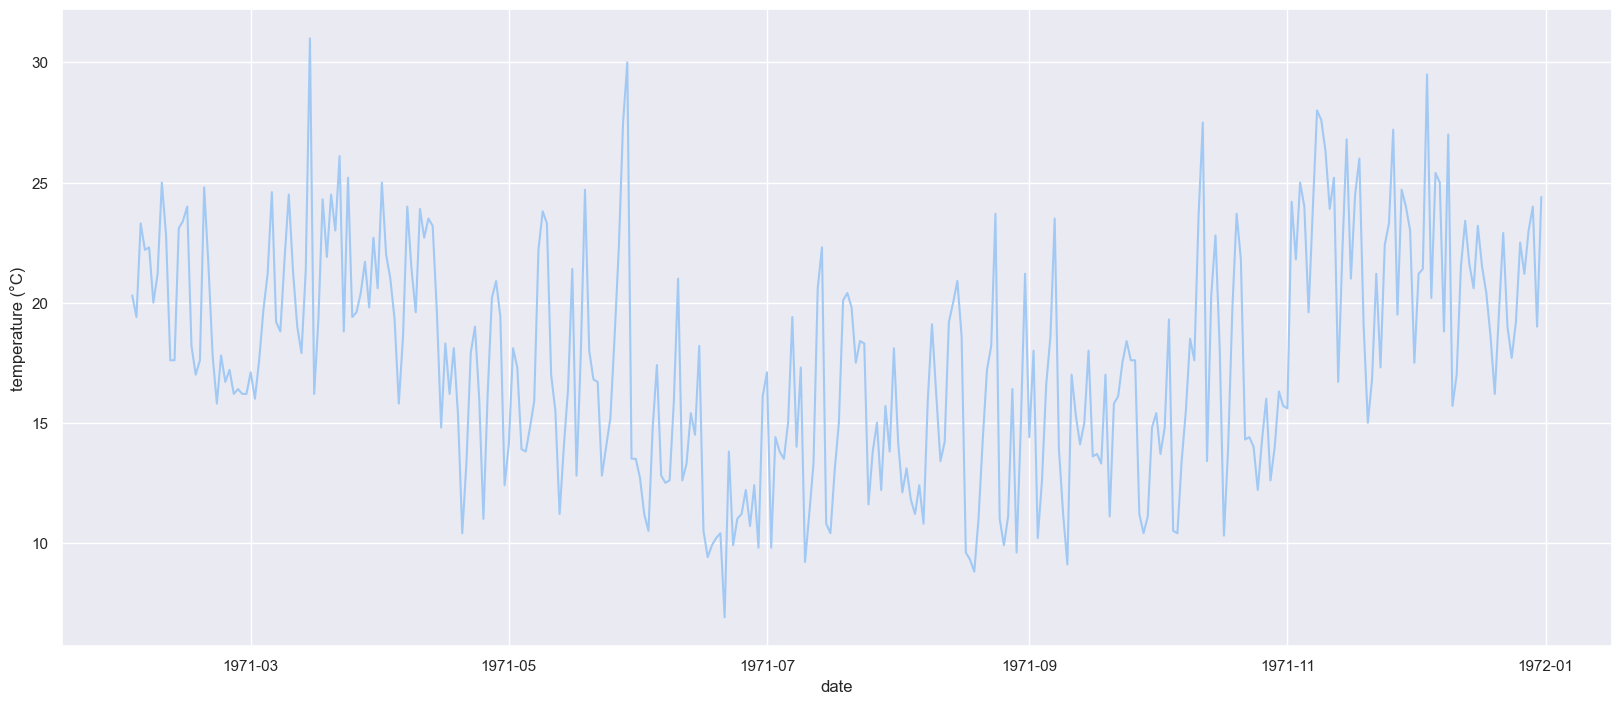

In [11]:
# Example of missing data
ii = 0
statlist[ii]

df_aux = stations_data[statlist[ii]]['max_temp'][stations_data[statlist[ii]].index.year > 1970]
df_aux = df_aux[df_aux.index.year < 2024]
plt.plot(df_aux[df_aux.index.year < 1972])# and stations_data[330030].index.year < 1972])
plt.xlabel('date')
plt.ylabel('temperature (°C)')

station_data_nans = df_aux[np.isnan(df_aux)]
#stations_data[statlist[ii]][np.isnan(stations_data[statlist[ii]]['mean_temp'])]
print(len(station_data_nans))
print(len(station_data_nans)/len(df_aux))